<a href="https://colab.research.google.com/github/bharadwaj-chukkala/Detection_of_Malignant_Skin_Cancer_using_a_CNN/blob/master/Detection_of_Malignant_Skin_Cancer_using_a_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Objective**: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

**Summary of the Skin Cancer Data**:

1. Total number of images: 2357
2. Images consist of Bening and Malignant Oncological Diseases.
3. Data was gathered by ISIC (International Skin Imaging Collaboration).
4. Images were sorted according to the classification taken with ISIC.
5. All the subsets were divided into the same number of images, with an excpetion for melanomas whose images are slightly dominant.

**Diseases in the Dataset**
 1. Actinic keratosis
 2. Basal cell carcinoma
 3. Dermatofibroma
 4. Melanoma
 5. Nevus
 6. Pigmented benign keratosis
 7. Seborrheic keratosis
 8. Squamous cell carcinoma
 9. Vascular lesion

## Importing Skin Cancer Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Path to the root directory i.e the Skin Cancer Data
data_path = 'drive/MyDrive/Colab Notebooks/Skin cancer Data'


### Importing all Libraries

In [26]:
import pathlib
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from glob import glob
import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.preprocessing.image import load_img

## Creating the Dataset:
1. Train Data Set
    - Train
    - Validation
2. Test Data Set

In [27]:
# Train DS Path
train_path = pathlib.Path(data_path + '/Train')

# Test DS Path
test_path = pathlib.Path(data_path + '/Test')

# Count of the images
training_img_count = len(list(train_path.glob('*/*.jpg')))      # Training Images
print(training_img_count)

testing_img_count = len(list(test_path.glob('*/*.jpg')))        # Testing Images
print(testing_img_count)

2239
118


Defining some parameters for the loader:

In [28]:
batch_size = 32
img_height = 180
img_width = 180
channels = 3

### Creating the Training Dataset:
1. Using 80% of the data for Training
2. Rest will be used for validation

In [29]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split = 0.2,
    subset = "training",
    seed = 123,
    image_size= (img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [30]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=0.2,
    subset = "validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [31]:
## Write your test dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 118 files belonging to 9 classes.


In [32]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.

class_names = train_ds.class_names
print(len(class_names))
print(class_names)

9
['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


## Visualize the Data

- We will visualize one image of each class listed in the Dataset

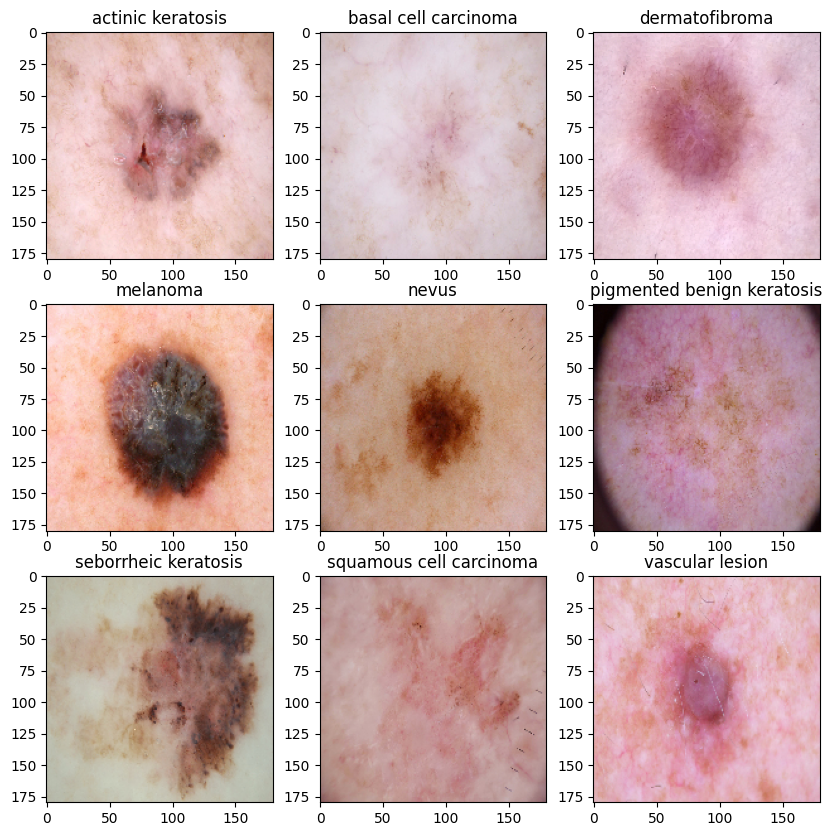

In [36]:
#Visualize one instance of all the class present in the dataset.
#image_dataset_from_directory() will return a tf.data.Dataset that yields batches of images from the subdirectories.
#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes), representing a one-hot encoding of the class index.

# Path to get categorical data

files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(train_path)+'/'+c+'/'+x, os.listdir(str(train_path)+'/'+c)))

plt.figure(figsize=(10,10))
i = 0
for c in class_names:
  path_list = files_path_dict[c][:1]
  i += 1
  plt.subplot(3,3,i)
  plt.imshow(load_img(path_list[0], target_size=(180,180)))
  plt.title(c)
  plt.axis=("off")


- Now let us visualize how the train data is distributed for each of the classes



In [41]:
# Count the number of images in each of the class
count = []

# Iterate through the train directory
for path in pathlib.Path(train_path).iterdir():
  if path.is_dir():
    count.append(len([name for name in os.listdir(path)
                            if os.path.isfile(os.path.join(path, name))]))
print(count)
# Iterate through name of classes
sub_dir = [name for name in os.listdir(train_path)
            if os.path.isdir(os.path.join(train_path, name ))]
print(sub_dir)

#create dataframe with image count and class
df = pd.DataFrame(zip(sub_dir, count), columns= ['Class', 'No. of Images'])
df

[139, 181, 77, 462, 357, 438, 95, 376, 114]
['vascular lesion', 'squamous cell carcinoma', 'seborrheic keratosis', 'pigmented benign keratosis', 'nevus', 'melanoma', 'dermatofibroma', 'basal cell carcinoma', 'actinic keratosis']


,Class,No. of Images
0,vascular lesion,139
1,squamous cell carcinoma,181
2,seborrheic keratosis,77
3,pigmented benign keratosis,462
4,nevus,357
5,melanoma,438
6,dermatofibroma,95
7,basal cell carcinoma,376
8,actinic keratosis,114


<Axes: xlabel='No. of Images', ylabel='Class'>

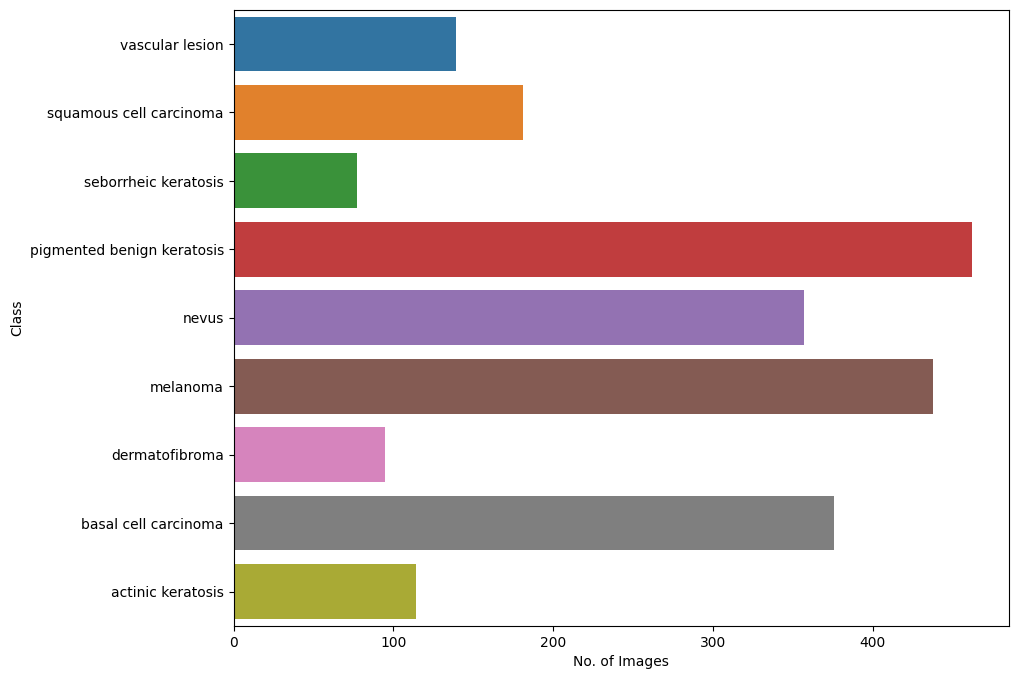

In [42]:
import seaborn as sns
plt.figure(figsize=(10,8))
sns.barplot(x ="No. of Images", y = "Class", data = df, label = 'Class')